In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 
from tensorflow.keras.backend import clear_session
import gc

In [25]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [26]:
to_drop=[
        "outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "y_deformation_position", "z_deformation_position",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio"
        ]
to_keep=[
        "pipe_dn","pipe_schedule","flange_class",
        "length1", "length2", "lumped_mass",
        "frequency","x_deformation_position","allowable_deformation","support"
        ]

data.drop(columns=to_drop,inplace=True)

In [27]:
numeric_features = [
    "pipe_dn",
    'length1', 'length2', 'lumped_mass',
    ]
categorical_features = ['support',"pipe_schedule","flange_class"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [28]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [29]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [31]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [32]:
scaler_y_frequency = StandardScaler()
scaler_y_allowed_deformation = StandardScaler()
scaler_y_x_position = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowed_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowed_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))

y_train_transformed_x_displacement = scaler_y_x_position.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y_x_position.transform(pd.DataFrame(y_test["x_deformation_position"]))



In [33]:
logdir = "logs/x_position_class/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [34]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(1024, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(hidden2)
hidden3 = Dense(64, activation='relu')(dropout2)

# Separate output for each target variable
output_layer = Dense(1)(hidden3)
#, name='allowable_deformation'


In [35]:
model = Model(inputs=input_layer, outputs=output_layer)

In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,321 (1.13 MB)

 Trainable params: 296,321 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [38]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_x_displacement,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - R2Score: 0.7981 - loss: 0.1971 - val_R2Score: 0.9507 - val_loss: 0.0479
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9515 - loss: 0.0473 - val_R2Score: 0.9313 - val_loss: 0.0667
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - R2Score: 0.9602 - loss: 0.0388 - val_R2Score: 0.9573 - val_loss: 0.0414
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - R2Score: 0.9631 - loss: 0.0382 - val_R2Score: 0.9715 - val_loss: 0.0276
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - R2Score: 0.9700 - loss: 0.0303 - val_R2Score: 0.9676 - val_loss: 0.0315
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - R2Score: 0.9701 - loss: 0.0303 - val_R2Score: 0.9654 - val_loss: 0.0335
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - R2Score: 0.9701 - loss: 0.0302 - val_R2Score: 0.9723 - val_loss: 0.0269
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - R2Score: 0.9734 - loss: 0.0259 - val_R2Score: 0.9761 

In [39]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_x_displacement)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2Score: 0.9726 - loss: 0.0253
Test accuracy: 0.9703408479690552


In [40]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 888,965 (3.39 MB)

 Trainable params: 296,321 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 592,644 (2.26 MB)

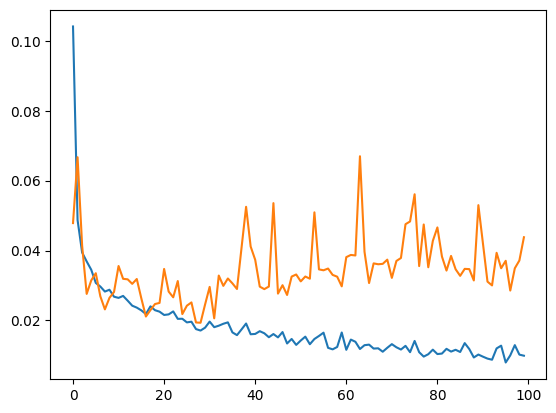

In [41]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [42]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_x_position.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [43]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
             0
0 -1356.988403
1  -345.275116
2  -295.419128
3  -375.142090
4  -405.719116


In [44]:
true= y_test["x_deformation_position"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

69508.32240881899

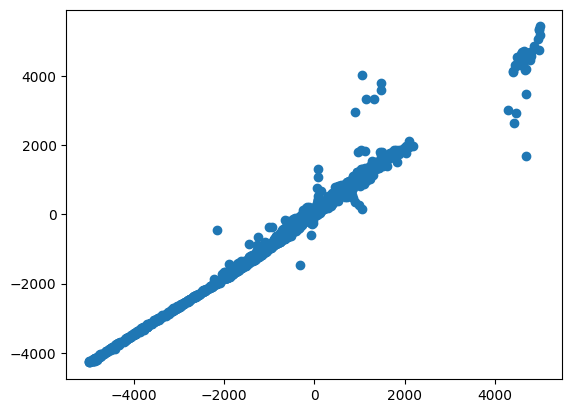

In [45]:
pred=predictions_df
ansys=y_test["x_deformation_position"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 150],[0, 150])
plt.show()

In [46]:
clear_session()
del model
gc.collect()

0